## Train a semantic segmentation unet using Pytorch

## Imports

In [8]:
from tifffile import imread
from tqdm import tqdm
from tnia.deeplearning.dl_helper import quantile_normalization
import matplotlib.pyplot as plt
import numpy as np
import torch

from torchvision import transforms
from torchvision.transforms import v2
import torchvision.transforms.functional as TF

## Check if GPU is present

In [9]:
cuda_present = torch.cuda.is_available()
ndevices = torch.cuda.device_count()
use_cuda = cuda_present and ndevices > 0
device = torch.device("cuda" if use_cuda else "cpu")  # "cuda:0" ... default device, "cuda:1" would be GPU index 1, "cuda:2" etc
print("number of devices:", ndevices, "\tchosen device:", device, "\tuse_cuda=", use_cuda)

number of devices: 1 	chosen device: cuda 	use_cuda= True


## Set up patch directories

We also collect some information about the patches, like the number of inputs, the number of ground truths and the axes types.

In [10]:
from pathlib import Path
import json

#tnia_images_path = Path("D:/images/tnia-python-images")
parent_path  = Path(r'D:\images\tnia-python-images\imagesc\2024_08_15_plant_roots') 

patch_path= parent_path / 'patches'

model_path = parent_path / 'models'

if not model_path.exists():
    model_path.mkdir()

with open(patch_path / 'info.json', 'r') as json_file:
    data = json.load(json_file)
    sub_sample = data.get('sub_sample',1)
    print('sub_sample',sub_sample)
    axes = data['axes']
    print('axes',axes)
    num_inputs = data['num_inputs']
    print('num_inputs',num_inputs)
    num_truths = data['num_truths']
    print('num_truths',num_truths)

label_patch_path = patch_path / 'ground truth0'
image_patch_path = patch_path / 'input0'

from glob import glob

tif_files = glob(str(image_patch_path / '*.tif'))

first_im = imread(tif_files[0])
target_shape=first_im.shape
print('target_shape',target_shape)

if axes == 'YX':
    num_in_channels=1
else:
    num_in_channels=3


sub_sample 1
axes YXC
num_inputs 1
num_truths 1
target_shape (196, 196, 3)


## Create a PyTorch Dataset

Dataset is simply used to retrieve the training patches.  In this case we just set it up to read in image files, then convert the numpy arrays to tensors and a torch stack.

In this example augmentation was done in a previous notebook, and the augmented images explicitly saved.  It is also possible to do augmentation as the data is retrieved.  So in the future the ```MyDataSet``` could be extended to apply augmentation as data is retrieved.

In [11]:
class MyDataSet():

    def __init__(self, image_files, label_files_list, target_shape=target_shape):
            """
            Parameters
            ----------
            image_files: list of pathlib.Path objects pointing to the *.tif images
            label_files_list: list of lists of pathlib.Path objects pointing to the *.tif segmentation masks
                        there are mulitple lists of label files each potentially representing one class
            target_shape: tuple of length 2 specifying the sample resolutions of files that
                        will be kept. All other files will NOT be used.
            """
            assert len(image_files) == len(label_files_list[0])
            assert all(x.name==y.name for x,y in zip(image_files, label_files_list[0]))

            self.images = []
            self.labels = []

            tensor_transform = transforms.Compose([
                v2.ToTensor(),
            ])

            # use tqdm to have eye pleasing error bars
            for idx in tqdm(range(len(image_files))):
                # we use the same data reading approach as in the previous notebook
                image = imread(image_files[idx])

                labels = []               
                for label_files in label_files_list:
                    label = imread(label_files[idx])
                    labels.append(label)

                if image.shape != target_shape:
                    continue
                
                
                labels_binary = []

                for label in labels:
                    label_binary = np.zeros_like(label).astype(np.float32)
                    label_binary[label != 0] = 1.
                    labels_binary.append(label_binary)

                image = tensor_transform(image)
                labels_binary = np.stack(labels_binary, axis=2)
                label = tensor_transform(labels_binary)

                self.images.append(image)
                self.labels.append(label)

            self.images = torch.stack(self.images)
            self.labels = torch.stack(self.labels)
    
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

    def __len__(self):
        return len(self.images)

## Initialize the DataSet 

Initialize the DataSet with the pre-generated patch names

In [12]:
# the source dir is the patch path
src_dir = patch_path

assert src_dir.exists(), f"root directory with images and masks {src_dir} does not exist"

# X is the list of input images
X = sorted(src_dir.rglob('**/input0/*.tif'))

# Y is a list of lists of segmentation masks (a.k.a. ground truths)
Y = []
for i in range(num_truths):
    Y.append(sorted(src_dir.rglob(f'**/ground truth{i}/*.tif')))

# create the dataset
train_data = MyDataSet(
    image_files=X,
    label_files_list=Y,
    target_shape=target_shape
)

# NOTE: the length of the dataset might not be the same as n_samples
# because files not having the target shape will be discarded
# it is a good idea to output the length of the dataset
# just to make sure we didn't mess up the target shape and discard all files
print(len(train_data))


c:\Users\bnort\miniconda3\envs\pytorch_and_SAM3\lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
100%|██████████| 2400/2400 [00:03<00:00, 605.80it/s]


2400


## Create a DataLoader

This is done so we can load batches of images. 

In [13]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_data, batch_size=128, shuffle=False)

## Create a UNET

Note:  In this case we don't use batch normalization because I found for the plant roots dataset it resulted in subpar training

(it seemed the statistics of some invidual images were very different than batch statistics, so if applying (and normalizing) a single image
the range ended up much different then the training batch)

In [14]:
from monai.networks.nets import BasicUNet

load = False

if load:
    model = torch.load(model_path / 'model1')
else:
    model = BasicUNet(
        spatial_dims=2,
        in_channels=num_in_channels,
        out_channels=num_truths,
        #features=[16, 16, 32, 64, 128, 16],
        act="relu",
        #norm="batch",
        dropout=0.25,
    )

    # Important: transfer the model to the chosen device
    model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1.e-4)
init_params = list(model.parameters())[0].clone().detach()

BasicUNet features: (32, 32, 64, 128, 256, 32).


## Train the UNET

In [15]:
max_nepochs = 100
log_interval = 128 
model.train(True)

optimizer = torch.optim.Adam(model.parameters(), lr=3.e-4)

# BCEWithLogitsLoss combines sigmoid + BCELoss for better
# numerical stability. It expects raw unnormalized scores as input which are shaped like 
# B x C x W x D
loss_function = torch.nn.BCEWithLogitsLoss(reduction="mean")

for epoch in range(1, max_nepochs + 1):
    for batch_idx, (X, y) in enumerate(train_loader):
        # the inputs and labels have to be on the same device as the model
        X, y = X.to(device), y.to(device)
        
        optimizer.zero_grad()

        prediction_logits = model(X)
        
        batch_loss = loss_function(prediction_logits, y)

        batch_loss.backward()

        optimizer.step()

        if True:#batch_idx % log_interval == 0:
            print(
                "Train Epoch:",
                epoch,
                "Batch:",
                batch_idx,
                "Total samples processed:",
                (batch_idx + 1) * train_loader.batch_size,
                "Loss:",
                batch_loss.item(),
            )

torch.save(model, model_path / 'model1')

Train Epoch: 1 Batch: 0 Total samples processed: 128 Loss: 0.6285784244537354
Train Epoch: 1 Batch: 1 Total samples processed: 256 Loss: 0.6145182251930237
Train Epoch: 1 Batch: 2 Total samples processed: 384 Loss: 0.6050267219543457
Train Epoch: 1 Batch: 3 Total samples processed: 512 Loss: 0.5976343750953674
Train Epoch: 1 Batch: 4 Total samples processed: 640 Loss: 0.5908706784248352
Train Epoch: 1 Batch: 5 Total samples processed: 768 Loss: 0.5513533353805542
Train Epoch: 1 Batch: 6 Total samples processed: 896 Loss: 0.5291162133216858
Train Epoch: 1 Batch: 7 Total samples processed: 1024 Loss: 0.5181983709335327
Train Epoch: 1 Batch: 8 Total samples processed: 1152 Loss: 0.5070844292640686
Train Epoch: 1 Batch: 9 Total samples processed: 1280 Loss: 0.5059857964515686
Train Epoch: 1 Batch: 10 Total samples processed: 1408 Loss: 0.5002706050872803
Train Epoch: 1 Batch: 11 Total samples processed: 1536 Loss: 0.49475300312042236
Train Epoch: 1 Batch: 12 Total samples processed: 1664 L

## Look at self-prediction

Self-prediction does not tell us how the UNET will perform on new data, but it is a useful check to make sure the UNET is learning the training data. 

torch.Size([96, 1, 196, 196])
torch.Size([128, 3, 196, 196])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


important info 0.0 1.2719231 0.43460208


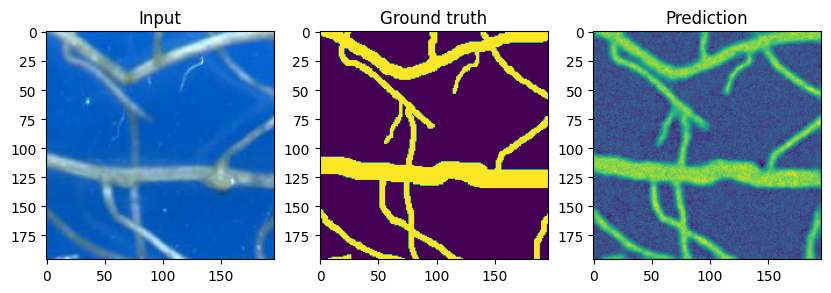

In [17]:
from cv2 import imshow
import matplotlib.pyplot as plt

# convert to 0/1 range on each pixel
prediction = torch.nn.functional.sigmoid(prediction_logits)
prediction_binary = prediction #(prediction > 0.5).to(torch.uint8)

print(prediction_binary.shape)

from tnia.plotting.plt_helper import imshow_multi2d

X = list(train_loader)[0][0]
y = list(train_loader)[0][1]
X = X.to(device)
prediction= model(X)

print(X.shape)

for sidx in range(1, 2):#len(X)):

    im = X[sidx, :].cpu().numpy()
    im = np.transpose(im, (1, 2, 0))
    
    print('important info',im.min(), im.max(), im.mean())
    
    gt = y[sidx, :].cpu().numpy()
    prediction_ = prediction[sidx, :].cpu().detach().numpy()
    
    imshow_multi2d([im, gt, prediction_], ['Input', 'Ground truth', 'Prediction'], 1, 3)

In [21]:
import napari
viewer = napari.Viewer()
viewer.add_image(im)
viewer.add_image(prediction_)

<Image layer 'prediction_' at 0x18c5d68d180>

## Save the UNET

In [18]:
torch.save(model, model_path / 'model1')